# **`flygym`-MuJoCo exercise: CPG controller** 

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_CPG_control.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).


In [2]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

from scipy.signal import medfilt
from scipy.integrate import ode


import PIL.Image

In [3]:
# Initialize simulation
run_time = 1
out_dir = Path('../CPGs')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 300),
                  'friction': (friction, 0.005, 0.0001)}

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs)

num_steps_base = int(run_time / nmf.timestep)

In [4]:
def plot_phase_amp_output(phases, amps, outs, labels=None):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].plot(phases, label=labels)
    axs[0].set_ylabel('Phase')
    axs[1].plot(amps, label=labels)
    axs[1].set_ylabel('Amplitude')
    axs[1].legend(loc="lower right")
    axs[2].plot(outs, label=labels)
    axs[2].set_ylabel('Output')
    axs[2].legend(loc="lower right")

    if labels:
        axs[0].legend(loc="lower right")
        axs[1].legend(loc="lower right")
        axs[2].legend(loc="lower right")


    plt.show()


# Coupled oscillators

A chain of oscillators can be defined by a set of differential equations. Those will direct the evolution of the phase and the amplitude of the output signal.

$\dot{\theta_i} = 2\pi\nu_i + \sum_j(r_jw_{ij}sin(\theta_j - \theta_i - \phi_{ij})) $


$\dot{r_i} = a_i*(R_i-r_i)$

At each timestep we solve those equation to get the next value of the phase $\theta_i$ and amplitude $r_i$ for each oscillator. $R_i$ is the taget amplitude, $a_i$ is the rate of convergence toward $R_i$, $w_{ij}$ is the couling strength between the oscillator i and j and finally $\phi_{ij}$ is the phase bias between the oscillator i and j. We will have to modify the phase bias values to obtain a tripod gait. 

The final output of the oscillator is given by:

$x_i = r_i(1+cos(\theta_i))$

Lets implement a network of such coupled oscillators.

We start by deffining the parameters 

In [5]:
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

dt = nmf.timestep  # seconds
t = np.arange(0, run_time, dt)

# lets say we want 10 oscillations in the time period
n_steps = 10
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitude = 1.0
target_amplitudes = np.ones(n_oscillators) * target_amplitude
rate = 10
rates = np.ones(n_oscillators) * rate

# Here we just build a chain of oscillators form 1 to 6
# They all have a bias of pi/6 from one to the other
bias = np.pi/3
# bias only above or bellow the main diagonal => only coupling between neighbouring oscillators
phase_biases = np.diag(np.ones(n_oscillators-1)*bias,k=1) - np.diag(np.ones(n_oscillators-1) * bias, k=-1)

# We wont play with the coupling weights yet so lets set it as the same as the phase biases
# As a consequence the oscillators that have a phase difference of zero are not coupled (depending on your implementation you might want to change that)
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 #* 10.0


Now the function that we are going to integrate

In [7]:
def phase_oscillator(_time, state):
    """Phase oscillator model used in Ijspeert et al. 2007"""
    
    phases = state[:n_oscillators]
    amplitudes = state[n_oscillators:2*n_oscillators]

    # NxN matrix with the phases of the oscillators
    phase_matrix = np.tile(phases, (n_oscillators, 1))

    # NxN matrix with the amplitudes of the oscillators
    amp_matrix = np.tile(amplitudes, (n_oscillators, 1))

    freq_contribution = 2*np.pi*frequencies

    #  scaling of the phase differences between oscillators by the amplitude of the oscillators and the coupling weights
    scaling = np.multiply(amp_matrix, coupling_weights)

    # phase matrix and transpose substraction are analogous to the phase differences between oscillators, those should be close to the phase biases
    phase_shifts_contribution = np.sin(phase_matrix-phase_matrix.T-phase_biases)

    # Here we compute the contribution of the phase biases to the derivative of the phases
    # we mulitply two NxN matrices and then sum over the columns (all j oscillators contributions) to get a vector of size N 
    coupling_contribution = np.sum(np.multiply(scaling, phase_shifts_contribution), axis=1)

    # Here we compute the derivative of the phases given by the equations defined previously. 
    # We are using for that matrix operations to speed up the computation
    dphases =  freq_contribution + coupling_contribution
    
    damplitudes = np.multiply(rates, target_amplitudes-amplitudes)
    
    return np.concatenate([dphases, damplitudes])

def sine_output(phases, amplitudes):
        return amplitudes * (1 + np.cos(phases))

Now we solve the dynamical system by running it step by step.

In [8]:
np.random.seed(42)

# Set solver
solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

# Initialize states and amplitudes
phases = np.zeros((num_steps_base, n_oscillators))
amplitudes = np.zeros((num_steps_base, n_oscillators))
output = np.zeros((num_steps_base, n_oscillators))

obs_list_tripod = []

for i in range(num_steps_base):

    res = solver.integrate(i*nmf.timestep)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp 
    output[i, :] = sine_output(phases[i, :], amplitudes[i, :])

/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dop853: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


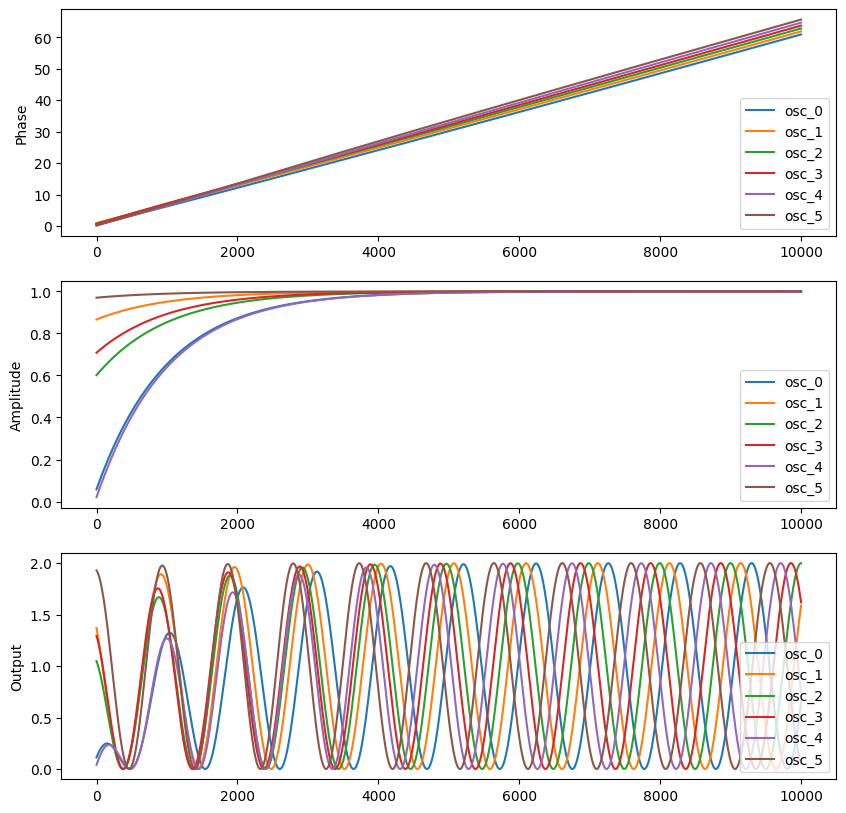

In [9]:
plot_phase_amp_output(phases, amplitudes, output, labels=["osc_"+str(i) for i in range(n_oscillators)])

# Tripod gait

To get a tripod gait, we will need to find the right phase biases that leeds to leg coordination. 
Then we will need to change the output function so that it outputs joint angles instead of a sinusoidal output. 

Lets change the output to be joint angles and not sine waves. We can use the phase and the amplitude to go through the stepping dataset used in the [decentralized control tutorial](https://github.com/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_decentralized_ctrl_basic.ipynb).

In [10]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
step_data_block_base = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    step_data_block_base[i, :] = np.interp(interp_t, measure_t, data[joint])

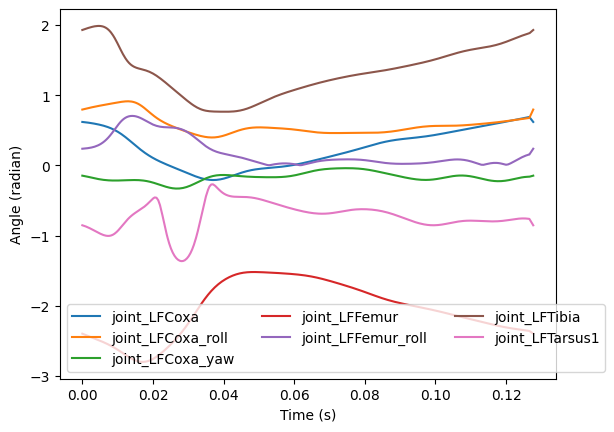

In [12]:
num_joints_to_visualize = 7
plt.plot(np.arange(step_data_block_base.shape[1]) * nmf.timestep,
         step_data_block_base[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend(ncol = 3)
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')
plt.show()

In [13]:
step_data_block_manualcorrect = step_data_block_base.copy()

for side in ["L", "R"]:
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}MCoxa")] += np.deg2rad(10) # Protract the midlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HFemur")] += np.deg2rad(-5) # Retract the hindlegs
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}HTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (also helps with the hindleg retraction)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FFemur")] += np.deg2rad(15) # Protract the forelegs (slightly to conterbalance Tarsus flexion)
    step_data_block_manualcorrect[nmf.actuated_joints.index(f"joint_{side}FTarsus1")] -= np.deg2rad(15) # Tarsus more parallel to the ground (flexed) (add some retraction of the forelegs)


In [14]:
n_joints = len(nmf.actuated_joints)

leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

def advancement_transfer(phases, step_dur=interp_step_duration):
    """From phase define what is the corresponding timepoint in the joint dataset
    In the case of the oscillator, the period is 2pi and the step duration is the period of the step
    We have to match those two"""

    period = 2*np.pi
    #match length of step to period phases should have a period of period mathc this perios to the one of the step
    t_indices = np.round(np.mod(phases*step_dur/period, step_dur-1)).astype(int)
    t_indices = t_indices[match_leg_to_joints]
    
    return t_indices

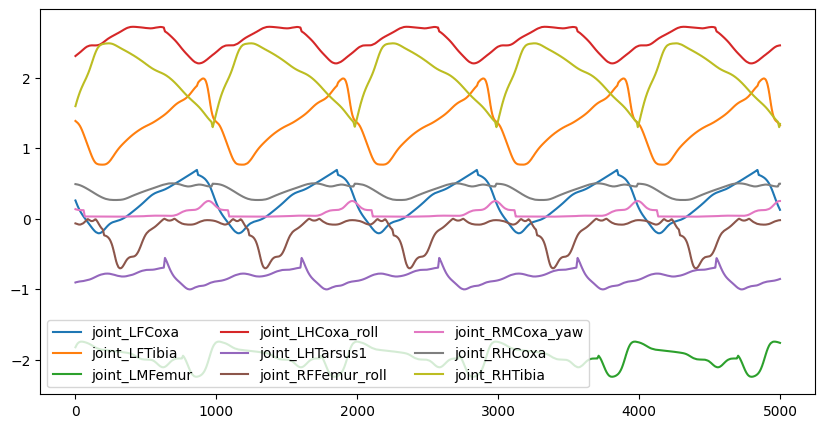

In [15]:
# Now we can try this mapping function to generate joint angles from the phases
joint_angles = []

for phase in phases[-5000:]: # using the phases from the toy example with constant delay
    t_indices = advancement_transfer(phase)
    joint_angles.append(step_data_block_manualcorrect[joint_ids, t_indices])

joint_angles = np.array(joint_angles)
fig = plt.figure(figsize=(10, 5))
plt.plot(joint_angles[:, ::5], label=nmf.actuated_joints[::5])
plt.legend(ncol = 3)
plt.show()    

For the tripod phase bias we can rely on the paper by [B. DeAngelis et al.](https://elifesciences.org/articles/46409). They report the distribution of phase biases for measured and idealised tripod giat. 
Here is are the figures reporting those values:

<p align="center">
<img align="center" width="500" src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/recorded_tripod.jpg">
<br><b>Phase bias distribution in the natural tripod gait.</b>
</p>


<p align="center">
<img align="center" width="1000" src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/idealized_gaits.jpg">
<br><b>Phase bias distribution in the natural tripod gait.</b>
</p>



In [16]:
# The bias matrix is define as follow: each line is the i oscillator and each column is the j oscillator couplign goes from i to j
# We express the bias in percentage of cycle 
phase_biases_measured= np.array([[0, 0.425, 0.85, 0.51, 0, 0],
                                  [0.425, 0, 0.425, 0, 0.51, 0],
                                  [0.85, 0.425, 0, 0, 0, 0.51],
                                  [0.51, 0, 0, 0, 0.425, 0.85],
                                  [0, 0.51, 0, 0.425, 0, 0.425],
                                  [0, 0, 0.51, 0.85, 0.425, 0]])
                                
phase_biases_idealized = np.array([[0, 0.5, 1.0, 0.5, 0, 0],
                                   [0.5, 0, 0.5, 0, 0.5, 0],
                                   [1.0, 0.5, 0, 0, 0, 0.5],
                                   [0.5, 0, 0, 0, 0.5, 1.0],
                                   [0, 0.5, 0, 0.5, 0, 0.5],
                                   [0, 0, 0.5, 1.0, 0.5, 0]]) 
# Phase bias of one is the same as zero (1 cycle difference)
# If we would use a phase bias of zero, we would need to change the coupling weight strategy

phase_biases = phase_biases_idealized * 2 * np.pi

coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 #* 10.0

# Simulation

In [17]:
np.random.seed(42)

_ = nmf.reset()

# Set solver
solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

n_stabilisation_steps = 1000
num_steps = n_stabilisation_steps + num_steps_base

phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))

obs_list_tripod = []

for i in range(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i> n_stabilisation_steps:
        indices = advancement_transfer(phase)
        # scale the amplitude of the joint angles to the output amplitude (High values of amplitude will highly alter the steps) 
        # With an amplitude of one, the joint angles will be the same as the one from the base step
        # With an amplitude of zero, the joint angles will be the same as the zero inidices of the base step (default pose)
        # The rest is a linear interpolation between those two
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0] + \
                  (step_data_block_manualcorrect[joint_ids, indices]-step_data_block_manualcorrect[joint_ids, 0])*amp[match_leg_to_joints]}
        #action = {'joints': step_data_block_base[joint_ids, indices]}
    else:
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}

    joint_angles[i, :] = action['joints']
    
    obs, info = nmf.step(action)
    obs_list_tripod.append(obs)
    nmf.render()

nmf.save_video(out_dir / "tripod.mp4")

/Users/stimpfli/miniconda3/envs/flygym/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dop853: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


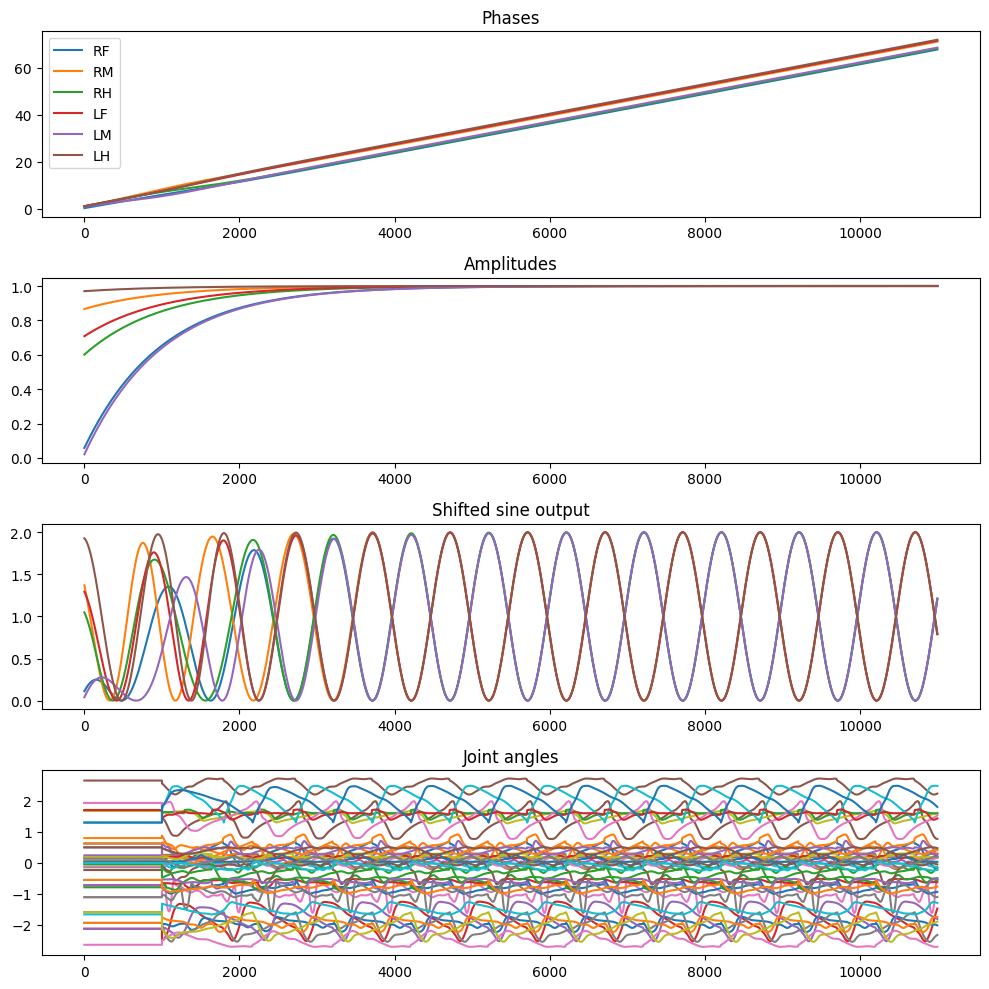

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(phases+np.arange(n_oscillators)*0.2, label=legs)
axs[0].set_title("Phases")
axs[0].legend()
axs[1].plot(amplitudes)
axs[1].set_title("Amplitudes")
axs[2].plot(sine_output(phases, amplitudes), label=legs)
axs[2].set_title("Shifted sine output")
axs[3].plot(joint_angles)
axs[3].set_title("Joint angles")

plt.tight_layout()

In [19]:
from ipywidgets import Video
Video.from_file(out_dir / 'tripod.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

# Turning

We can try to implement turning by increasing the frequency in the legs on one side of the body

In [20]:
np.random.seed(42)

_ = nmf.reset()

# Set solver
solver = ode(f=phase_oscillator)
solver.set_integrator('dop853')
initial_values = np.random.rand(2*n_oscillators)
solver.set_initial_value(y=initial_values, t=nmf.curr_time)

n_stabilisation_steps = 1000
num_steps = n_stabilisation_steps + num_steps_base

phases = np.zeros((num_steps, n_oscillators))
amplitudes = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))

turn_start, turn_end = 4000, 8000

# To turn, we can increase the frequency in the legs on the right
base_frequencies = frequencies.copy()
turn_frequencies = frequencies.copy()
for i, leg in enumerate(legs):
    if "R" in leg:
        turn_frequencies[i] *= 2.0

# To turn, we can increase the amplitude in the legs on the right
base_target_amplitudes = target_amplitudes.copy()
turn_target_amplitudes = target_amplitudes.copy()
for i, leg in enumerate(legs):
    if "R" in leg:
        turn_target_amplitudes[i] = 1.
    else:
        turn_target_amplitudes[i] = 0

obs_list_tripod = []

for i in range(num_steps):

    if i > turn_start and i < turn_end:
        frequencies = turn_frequencies
        #target_amplitudes = turn_target_amplitudes
    else:
        frequencies = base_frequencies
        #target_amplitudes = base_target_amplitudes

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i> n_stabilisation_steps:
        indices = advancement_transfer(phase)
        # scale the amplitude of the joint angles to the output amplitude (High values of amplitude will highly alter the steps) 
        # With an amplitude of one, the joint angles will be the same as the one from the base step
        # With an amplitude of zero, the joint angles will be the same as the zero inidices of the base step (default pose)
        # The rest is a linear interpolation between those two
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0] + \
                   (step_data_block_manualcorrect[joint_ids, indices]-step_data_block_manualcorrect[joint_ids, 0])*amp[match_leg_to_joints]}
        #action = {'joints': step_data_block_base[joint_ids, indices]}
    else:
        action = {'joints': step_data_block_manualcorrect[joint_ids, 0]}



    joint_angles[i, :] = action['joints']
    
    obs, info = nmf.step(action)
    obs_list_tripod.append(obs)
    nmf.render()

nmf.save_video(out_dir / "tripod_turn.mp4")

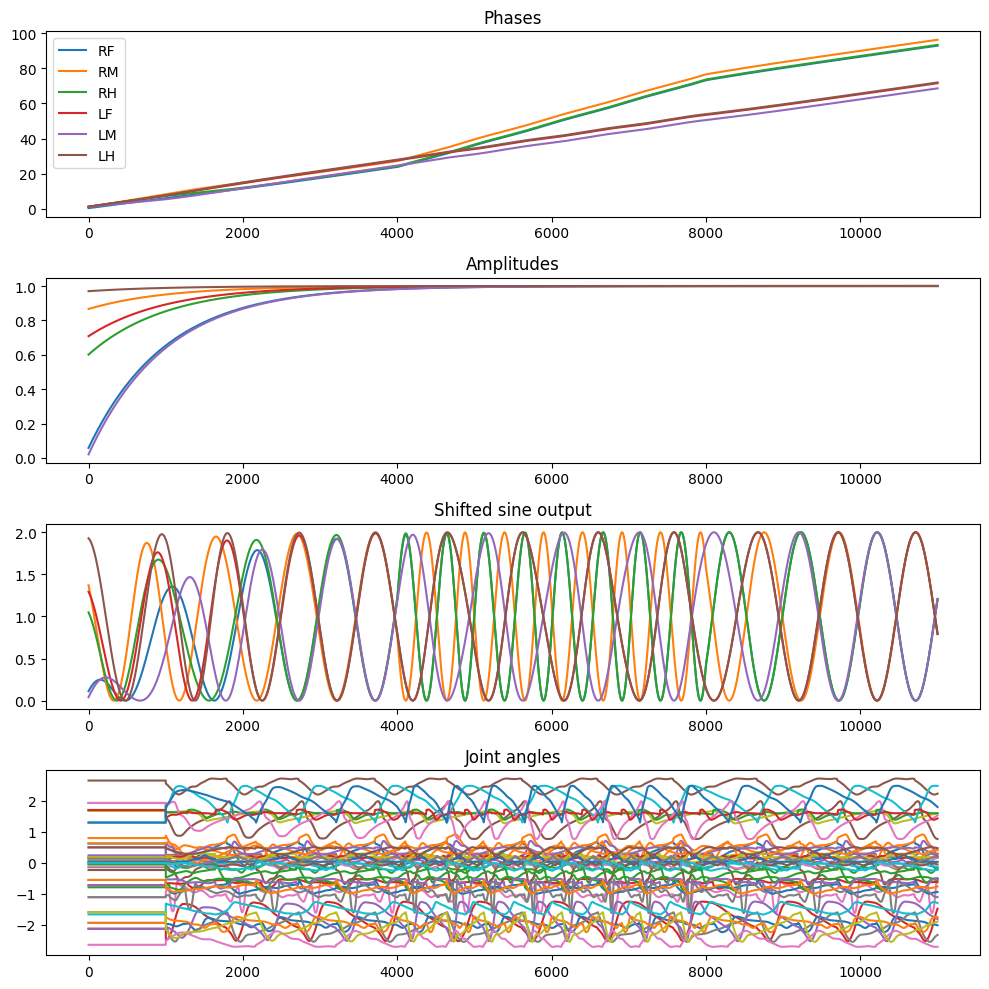

In [21]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
axs[0].plot(phases+np.arange(n_oscillators)*0.2, label=legs)
axs[0].set_title("Phases")
axs[0].legend()
axs[1].plot(amplitudes)
axs[1].set_title("Amplitudes")
axs[2].plot(sine_output(phases, amplitudes), label=legs)
axs[2].set_title("Shifted sine output")
axs[3].plot(joint_angles)
axs[3].set_title("Joint angles")

plt.tight_layout()

In [22]:
from ipywidgets import Video
Video.from_file(out_dir / 'tripod_turn.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')